# Chess Rating Prediction 

This notebook explores various machine learning and time series models for predicting chess ratings.

## Models to try:
- **Baseline**: Moving Average, EMA, Last Value
- **Linear**: Ridge, Lasso, ElasticNet
- **Tree-based**: Random Forest, Gradient Boosting, XGBoost, LightGBM
- **Time Series**: ARIMA, Exponential Smoothing
- **Prophet**: Facebook Prophet
- **Deep Learning**: LSTM
- **Ensemble**: Stacking

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import json
import os
import pickle
import warnings
from datetime import datetime, timedelta
from pathlib import Path
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Preprocessing & Validation
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error
)

# Linear Models
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, HuberRegressor
)

# Tree Models
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    AdaBoostRegressor, ExtraTreesRegressor,
    StackingRegressor, VotingRegressor
)
from sklearn.tree import DecisionTreeRegressor

# Other
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Boosting
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost not installed, skipping...")

try:
    import lightgbm as lgb
    HAS_LGB = True
except ImportError:
    HAS_LGB = False
    print("LightGBM not installed, skipping...")

# Time Series Models
try:
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from statsmodels.tsa.stattools import adfuller, acf, pacf
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False
    print("Statsmodels not installed, skipping...")

# Prophet
try:
    from prophet import Prophet
    HAS_PROPHET = True
except ImportError:
    HAS_PROPHET = False
    print("Prophet not installed, skipping...")

# Deep Learning
try:
    import tensorflow as tf
    from tensorflow import keras
    from keras.models import Sequential
    from keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from keras.regularizers import l2
    HAS_KERAS = True
except ImportError:
    HAS_KERAS = False
    print("TensorFlow/Keras not installed, skipping...")

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All imports successful!")
print(f"\nAvailable libraries:")
print(f"  XGBoost: {HAS_XGB}")
print(f"  LightGBM: {HAS_LGB}")
print(f"  Statsmodels: {HAS_STATSMODELS}")
print(f"  Prophet: {HAS_PROPHET}")
print(f"  TensorFlow/Keras: {HAS_KERAS}")

c:\Users\vitus\Desktop\master\master_project\chess-app\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All imports successful!

Available libraries:
  XGBoost: True
  LightGBM: True
  Statsmodels: True
  Prophet: True
  TensorFlow/Keras: True


In [2]:
# Configuration
CONFIG = {
    'data_dir': 'bucket_data',
    'output_dir': 'rating_models',
    'buckets': [
        '800-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800',
        '1800-2000', '2000-2200', '2200-2400', '2400_plus'
    ],
    'forecast_days': 30,
    'test_size': 0.2,
    'cv_splits': 5,
    'random_state': RANDOM_STATE
}

os.makedirs(CONFIG['output_dir'], exist_ok=True)
print("Configuration loaded!")

Configuration loaded!


## 2. Data Loading

In [3]:
def load_bucket_data(bucket_name, data_dir):
    """Load games data for a specific bucket."""
    safe_name = bucket_name.replace('+', '_plus')
    file_path = os.path.join(data_dir, f"bucket_{safe_name}_games.json")
    
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found")
        return None
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    return data


def parse_games_to_rating_df(games_dict, bucket_name):
    """Parse games to extract rating time series data."""
    rows = []
    
    for username, games in games_dict.items():
        for game in games:
            try:
                players = game.get('players', {})
                white_info = players.get('white', {})
                black_info = players.get('black', {})
                
                white_user = white_info.get('user', {}).get('name', '').lower()
                black_user = black_info.get('user', {}).get('name', '').lower()
                
                is_white = white_user == username.lower()
                player_color = 'white' if is_white else 'black'
                
                player_info = white_info if is_white else black_info
                opponent_info = black_info if is_white else white_info
                
                player_rating = player_info.get('rating')
                opponent_rating = opponent_info.get('rating')
                
                if not player_rating or not opponent_rating:
                    continue
                
                # Outcome
                winner = game.get('winner')
                if winner == player_color:
                    outcome = 1.0  # win
                elif winner is None:
                    outcome = 0.5  # draw
                else:
                    outcome = 0.0  # loss
                
                # Time data
                clocks = game.get('clocks', [])
                time_trouble = 0
                avg_time_per_move = None
                
                if clocks and len(clocks) > 0:
                    player_clocks = []
                    for idx, clock in enumerate(clocks):
                        if (idx % 2 == 0 and is_white) or (idx % 2 == 1 and not is_white):
                            player_clocks.append(clock / 100)
                    
                    if player_clocks:
                        min_clock = min(player_clocks)
                        time_trouble = 1 if min_clock < 30 else 0
                        
                        if len(player_clocks) > 1:
                            time_diffs = [player_clocks[i] - player_clocks[i+1] 
                                         for i in range(len(player_clocks)-1)]
                            positive_diffs = [t for t in time_diffs if t > 0]
                            avg_time_per_move = np.mean(positive_diffs) if positive_diffs else None
                
                # Opening
                opening = game.get('opening', {})
                opening_eco = opening.get('eco', 'A00')
                
                # Moves count
                moves_str = game.get('moves', '')
                num_moves = len(moves_str.split()) // 2 if moves_str else 0
                
                # Timestamp
                created_at = game.get('createdAt', 0)
                game_date = datetime.fromtimestamp(created_at / 1000) if created_at else None
                
                rows.append({
                    'bucket': bucket_name,
                    'date': game_date,
                    'username': username.lower(),
                    'player_rating': player_rating,
                    'opponent_rating': opponent_rating,
                    'rating_diff': opponent_rating - player_rating,
                    'outcome': outcome,
                    'player_color': 1 if is_white else 0,
                    'time_trouble': time_trouble,
                    'avg_time_per_move': avg_time_per_move,
                    'num_moves': num_moves,
                    'opening_eco': opening_eco,
                    'speed': game.get('speed', 'blitz')
                })
                
            except Exception as e:
                continue
    
    return pd.DataFrame(rows)

In [4]:
# Load all bucket data
print("Loading data from all buckets...\n")

all_dfs = []
for bucket in CONFIG['buckets']:
    data = load_bucket_data(bucket, CONFIG['data_dir'])
    if data:
        df = parse_games_to_rating_df(data, bucket)
        if len(df) > 0:
            all_dfs.append(df)
            print(f"  {bucket}: {len(df):,} games from {len(data)} users")

# Combine all data
df_all = pd.concat(all_dfs, ignore_index=True)
df_all['date'] = pd.to_datetime(df_all['date'])
df_all = df_all.sort_values('date').reset_index(drop=True)

print(f"\n Total: {len(df_all):,} games loaded")
print(f"   Date range: {df_all['date'].min()} to {df_all['date'].max()}")
print(f"   Unique users: {df_all['username'].nunique():,}")

Loading data from all buckets...

  800-1000: 68,474 games from 335 users
  1000-1200: 69,638 games from 338 users
  1200-1400: 70,539 games from 336 users
  1400-1600: 70,434 games from 338 users
  1600-1800: 67,658 games from 323 users
  1800-2000: 70,545 games from 336 users
  2000-2200: 68,806 games from 329 users
  2200-2400: 66,512 games from 317 users
  2400_plus: 64,895 games from 312 users

 Total: 617,501 games loaded
   Date range: 2018-04-01 11:39:25.407000 to 2025-12-24 14:08:16.959000
   Unique users: 2,964


In [5]:
# Quick data exploration
print("Data shape:", df_all.shape)
print("\nColumn types:")
display(df_all.dtypes)
print("\nMissing values:")
display(df_all.isnull().sum())
print("\nRating statistics:")
display(df_all['player_rating'].describe())

Data shape: (617501, 13)

Column types:


bucket                       object
date                 datetime64[ns]
username                     object
player_rating                 int64
opponent_rating               int64
rating_diff                   int64
outcome                     float64
player_color                  int64
time_trouble                  int64
avg_time_per_move           float64
num_moves                     int64
opening_eco                  object
speed                        object
dtype: object


Missing values:


bucket                  0
date                    0
username                0
player_rating           0
opponent_rating         0
rating_diff             0
outcome                 0
player_color            0
time_trouble            0
avg_time_per_move    3636
num_moves               0
opening_eco             0
speed                   0
dtype: int64


Rating statistics:


count   617501.0000
mean      1722.5278
std        483.2233
min        400.0000
25%       1328.0000
50%       1712.0000
75%       2117.0000
max       3113.0000
Name: player_rating, dtype: float64

## 3. Feature Engineering for Rating Prediction

In [6]:
def create_user_rating_series(df, username, min_games=20):
    """
    Create a rating time series for a specific user.
    Returns daily aggregated features.
    """
    user_df = df[df['username'] == username].copy()
    
    if len(user_df) < min_games:
        return None
    
    user_df = user_df.sort_values('date')
    
    daily = user_df.groupby(user_df['date'].dt.date).agg({
        'player_rating': 'last',  
        'outcome': ['sum', 'count', 'mean'],  
        'opponent_rating': 'mean',
        'rating_diff': 'mean',
        'time_trouble': 'mean',
        'num_moves': 'mean'
    }).reset_index()
    
    daily.columns = ['date', 'rating', 'daily_wins', 'daily_games', 'daily_winrate',
                     'avg_opponent_rating', 'avg_rating_diff', 'time_trouble_rate', 'avg_moves']
    
    daily['date'] = pd.to_datetime(daily['date'])
    daily = daily.sort_values('date').reset_index(drop=True)
    
    return daily


def create_features_for_prediction(df, lookback_windows=[3, 7, 14, 30]):
    """
    Create features for rating prediction.
    """
    df = df.copy()
    
    for lag in [1, 2, 3, 5, 7]:
        df[f'rating_lag_{lag}'] = df['rating'].shift(lag)
    
    # Rolling statistics (SHIFTED!)
    for window in lookback_windows:
        # Rating stats
        df[f'rating_ma_{window}'] = df['rating'].shift(1).rolling(window, min_periods=1).mean()
        df[f'rating_std_{window}'] = df['rating'].shift(1).rolling(window, min_periods=1).std()
        df[f'rating_min_{window}'] = df['rating'].shift(1).rolling(window, min_periods=1).min()
        df[f'rating_max_{window}'] = df['rating'].shift(1).rolling(window, min_periods=1).max()
        
        # Performance stats
        df[f'winrate_ma_{window}'] = df['daily_winrate'].shift(1).rolling(window, min_periods=1).mean()
        df[f'games_ma_{window}'] = df['daily_games'].shift(1).rolling(window, min_periods=1).mean()
    
    # Trend features
    df['rating_change_1d'] = df['rating'].diff().shift(1)
    df['rating_change_7d'] = (df['rating'] - df['rating'].shift(7)).shift(1)
    df['rating_change_14d'] = (df['rating'] - df['rating'].shift(14)).shift(1)
    df['rating_change_30d'] = (df['rating'] - df['rating'].shift(30)).shift(1)
    
    # Momentum (EMA)
    df['rating_ema_7'] = df['rating'].shift(1).ewm(span=7, adjust=False).mean()
    df['rating_ema_14'] = df['rating'].shift(1).ewm(span=14, adjust=False).mean()
    df['rating_ema_30'] = df['rating'].shift(1).ewm(span=30, adjust=False).mean()
    
    # Volatility
    df['rating_volatility_7'] = df['rating_change_1d'].shift(1).rolling(7, min_periods=1).std()
    df['rating_volatility_14'] = df['rating_change_1d'].shift(1).rolling(14, min_periods=1).std()
    
    # Streaks (consecutive wins/losses)
    df['win_streak'] = (df['daily_winrate'] > 0.5).astype(int)
    df['win_streak'] = df['win_streak'].groupby((df['win_streak'] != df['win_streak'].shift()).cumsum()).cumsum()
    df['win_streak'] = df['win_streak'].shift(1)
    
    # Time features
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Fill NaN for rolling features
    df = df.fillna(method='bfill').fillna(method='ffill')
    
    return df

In [7]:
user_game_counts = df_all.groupby('username').size().sort_values(ascending=False)
print(f"Users with 50+ games: {(user_game_counts >= 50).sum()}")
print(f"Users with 100+ games: {(user_game_counts >= 100).sum()}")
print(f"Users with 200+ games: {(user_game_counts >= 200).sum()}")

# Select top users for analysis
top_users = user_game_counts[user_game_counts >= 100].index.tolist()
print(f"\nSelected {len(top_users)} users for analysis")

Users with 50+ games: 2959
Users with 100+ games: 2944
Users with 200+ games: 2911

Selected 2944 users for analysis


In [8]:
# Create feature datasets for multiple users
print("Creating feature datasets...\n")

all_features = []
sample_users = top_users[:50]  # Use top 50 users for training

for username in sample_users:
    daily_df = create_user_rating_series(df_all, username, min_games=50)
    if daily_df is not None and len(daily_df) >= 30:
        features_df = create_features_for_prediction(daily_df)
        features_df['username'] = username
        all_features.append(features_df)

df_features = pd.concat(all_features, ignore_index=True)
print(f" Created features for {len(all_features)} users")
print(f"   Total samples: {len(df_features):,}")
print(f"   Features: {df_features.shape[1]}")

Creating feature datasets...

 Created features for 9 users
   Total samples: 393
   Features: 52


In [9]:
# Define feature columns (excluding target and identifiers)
exclude_cols = ['date', 'username', 'rating']
FEATURE_COLS = [col for col in df_features.columns if col not in exclude_cols]

print(f"Feature columns ({len(FEATURE_COLS)}):")
for i, col in enumerate(FEATURE_COLS):
    print(f"  {i+1}. {col}")

Feature columns (49):
  1. daily_wins
  2. daily_games
  3. daily_winrate
  4. avg_opponent_rating
  5. avg_rating_diff
  6. time_trouble_rate
  7. avg_moves
  8. rating_lag_1
  9. rating_lag_2
  10. rating_lag_3
  11. rating_lag_5
  12. rating_lag_7
  13. rating_ma_3
  14. rating_std_3
  15. rating_min_3
  16. rating_max_3
  17. winrate_ma_3
  18. games_ma_3
  19. rating_ma_7
  20. rating_std_7
  21. rating_min_7
  22. rating_max_7
  23. winrate_ma_7
  24. games_ma_7
  25. rating_ma_14
  26. rating_std_14
  27. rating_min_14
  28. rating_max_14
  29. winrate_ma_14
  30. games_ma_14
  31. rating_ma_30
  32. rating_std_30
  33. rating_min_30
  34. rating_max_30
  35. winrate_ma_30
  36. games_ma_30
  37. rating_change_1d
  38. rating_change_7d
  39. rating_change_14d
  40. rating_change_30d
  41. rating_ema_7
  42. rating_ema_14
  43. rating_ema_30
  44. rating_volatility_7
  45. rating_volatility_14
  46. win_streak
  47. day_of_week
  48. month
  49. is_weekend


In [10]:
print("Missing values before cleaning:")
display(df_features[FEATURE_COLS].isnull().sum().sum())

# Drop rows with missing values in features
df_clean = df_features.dropna(subset=FEATURE_COLS + ['rating'])
display(f"\nSamples after cleaning: {len(df_clean):,}")

Missing values before cleaning:


np.int64(0)

'\nSamples after cleaning: 393'

## 4. Train/Test Split (Time Series Aware)

In [11]:
# NOTE: Use time-based split, NOT random split!

df_clean = df_clean.sort_values('date').reset_index(drop=True)

# Split by time (80% train, 20% test)
split_idx = int(len(df_clean) * 0.8)

train_df = df_clean.iloc[:split_idx].copy()
test_df = df_clean.iloc[split_idx:].copy()

print(f"Train set: {len(train_df):,} samples")
print(f"  Date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"\nTest set: {len(test_df):,} samples")
print(f"  Date range: {test_df['date'].min()} to {test_df['date'].max()}")

# Prepare X and y
X_train = train_df[FEATURE_COLS].values
y_train = train_df['rating'].values
X_test = test_df[FEATURE_COLS].values
y_test = test_df['rating'].values

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Train set: 314 samples
  Date range: 2025-01-01 00:00:00 to 2025-11-23 00:00:00

Test set: 79 samples
  Date range: 2025-11-23 00:00:00 to 2025-12-24 00:00:00

X_train shape: (314, 49)
X_test shape: (79, 49)


In [12]:
# Scale features
scaler = RobustScaler()  # Robust to outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using RobustScaler")

Features scaled using RobustScaler


## 5. Baseline Models

In [13]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and return evaluation metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

results = []

In [14]:
# Baseline 1: Last Value (Naive)
# Predict the same rating as the last known value
y_pred_naive = test_df['rating_lag_1'].values
results.append(evaluate_model(y_test, y_pred_naive, 'Naive (Last Value)'))
print(" Naive baseline completed")

# Baseline 2: Moving Average (7 days)
y_pred_ma7 = test_df['rating_ma_7'].values
results.append(evaluate_model(y_test, y_pred_ma7, 'Moving Average (7d)'))
print(" MA-7 baseline completed")

# Baseline 3: Moving Average (30 days)
y_pred_ma30 = test_df['rating_ma_30'].values
results.append(evaluate_model(y_test, y_pred_ma30, 'Moving Average (30d)'))
print(" MA-30 baseline completed")

# Baseline 4: EMA (14 days)
y_pred_ema = test_df['rating_ema_14'].values
results.append(evaluate_model(y_test, y_pred_ema, 'EMA (14d)'))
print(" EMA-14 baseline completed")

 Naive baseline completed
 MA-7 baseline completed
 MA-30 baseline completed
 EMA-14 baseline completed


## 6. Linear Models

In [15]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=CONFIG['cv_splits'])

def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    """Train model and evaluate with CV."""
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
    cv_mae = -cv_scores.mean()
    
    # Fit on full training set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    result = evaluate_model(y_test, y_pred, model_name)
    result['CV_MAE'] = cv_mae
    
    return result, model, y_pred

In [16]:
# Linear Regression
lr = LinearRegression()
result, model_lr, pred_lr = train_and_evaluate(lr, 'Linear Regression', X_train_scaled, y_train, X_test_scaled, y_test)
results.append(result)
print(f" Linear Regression - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 Linear Regression - MAE: 3.07, R2: 0.9999


In [17]:
# Ridge Regression (L2 regularization)
ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
result, model_ridge, pred_ridge = train_and_evaluate(ridge, 'Ridge Regression', X_train_scaled, y_train, X_test_scaled, y_test)
results.append(result)
print(f" Ridge Regression - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 Ridge Regression - MAE: 6.78, R2: 0.9998


In [18]:
# Lasso Regression (L1 regularization)
lasso = Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=10000)
result, model_lasso, pred_lasso = train_and_evaluate(lasso, 'Lasso Regression', X_train_scaled, y_train, X_test_scaled, y_test)
results.append(result)
print(f" Lasso Regression - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 Lasso Regression - MAE: 3.28, R2: 0.9999


In [19]:
# ElasticNet (L1 + L2)
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=10000)
result, model_elastic, pred_elastic = train_and_evaluate(elastic, 'ElasticNet', X_train_scaled, y_train, X_test_scaled, y_test)
results.append(result)
print(f" ElasticNet - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 ElasticNet - MAE: 7.10, R2: 0.9998


In [20]:
# Bayesian Ridge
bayesian = BayesianRidge()
result, model_bayesian, pred_bayesian = train_and_evaluate(bayesian, 'Bayesian Ridge', X_train_scaled, y_train, X_test_scaled, y_test)
results.append(result)
print(f" Bayesian Ridge - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 Bayesian Ridge - MAE: 3.15, R2: 0.9999


In [21]:
# Huber Regressor (robust to outliers)
huber = HuberRegressor(max_iter=1000)
result, model_huber, pred_huber = train_and_evaluate(huber, 'Huber Regressor', X_train_scaled, y_train, X_test_scaled, y_test)
results.append(result)
print(f" Huber Regressor - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 Huber Regressor - MAE: 2.81, R2: 0.9999


## 7. Tree-Based Models

In [22]:
# Random Forest (with regularization to prevent overfitting)
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,  # Limit depth to prevent overfitting
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
result, model_rf, pred_rf = train_and_evaluate(rf, 'Random Forest', X_train_scaled, y_train, X_test_scaled, y_test)
results.append(result)
print(f" Random Forest - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 Random Forest - MAE: 19.07, R2: 0.9981


In [23]:
# Extra Trees
et = ExtraTreesRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
result, model_et, pred_et = train_and_evaluate(et, 'Extra Trees', X_train_scaled, y_train, X_test_scaled, y_test)
results.append(result)
print(f" Extra Trees - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 Extra Trees - MAE: 13.16, R2: 0.9991


In [24]:
# Gradient Boosting
gb = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,  # Prevent overfitting
    random_state=RANDOM_STATE
)
result, model_gb, pred_gb = train_and_evaluate(gb, 'Gradient Boosting', X_train_scaled, y_train, X_test_scaled, y_test)
results.append(result)
print(f" Gradient Boosting - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 Gradient Boosting - MAE: 11.87, R2: 0.9992


In [25]:
# XGBoost
if HAS_XGB:
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,  # L1 regularization
        reg_lambda=1.0,  # L2 regularization
        random_state=RANDOM_STATE,
        verbosity=0
    )
    result, model_xgb, pred_xgb = train_and_evaluate(xgb_model, 'XGBoost', X_train_scaled, y_train, X_test_scaled, y_test)
    results.append(result)
    print(f" XGBoost - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 XGBoost - MAE: 47.92, R2: 0.9443


In [26]:
# LightGBM
if HAS_LGB:
    lgb_model = lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        verbosity=-1
    )
    result, model_lgb, pred_lgb = train_and_evaluate(lgb_model, 'LightGBM', X_train_scaled, y_train, X_test_scaled, y_test)
    results.append(result)
    print(f" LightGBM - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 LightGBM - MAE: 14.34, R2: 0.9989


## 8. Other ML Models

In [27]:
# KNN Regressor
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
result, model_knn, pred_knn = train_and_evaluate(knn, 'KNN Regressor', X_train_scaled, y_train, X_test_scaled, y_test)
results.append(result)
print(f" KNN Regressor - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 KNN Regressor - MAE: 49.84, R2: 0.9877


In [28]:
# SVR (on smaller sample for speed)
sample_size = min(5000, len(X_train_scaled))
indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_train_sample = X_train_scaled[indices]
y_train_sample = y_train[indices]

svr = SVR(kernel='rbf', C=100, epsilon=1.0)
svr.fit(X_train_sample, y_train_sample)
pred_svr = svr.predict(X_test_scaled)
result = evaluate_model(y_test, pred_svr, 'SVR')
results.append(result)
print(f" SVR - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 SVR - MAE: 51.25, R2: 0.9783


## 9. Time Series Models (ARIMA, Exponential Smoothing)

In [29]:
# Select a single user for time series modeling demo

if HAS_STATSMODELS:
    sample_user = sample_users[0]
    user_daily = create_user_rating_series(df_all, sample_user, min_games=50)
    
    if user_daily is not None and len(user_daily) >= 60:
        # Split
        train_size = int(len(user_daily) * 0.8)
        ts_train = user_daily['rating'].iloc[:train_size]
        ts_test = user_daily['rating'].iloc[train_size:]
        
        print(f"Time series for user: {sample_user}")
        print(f"  Train: {len(ts_train)}, Test: {len(ts_test)}")
    else:
        print("Not enough data for time series models")
        HAS_STATSMODELS = False

Not enough data for time series models


In [30]:
# ARIMA Model
if HAS_STATSMODELS and len(ts_train) >= 30:
    try:
        # Simple ARIMA(1,1,1)
        arima_model = ARIMA(ts_train, order=(1, 1, 1))
        arima_fit = arima_model.fit()
        
        # Forecast
        arima_pred = arima_fit.forecast(steps=len(ts_test))
        
        result = evaluate_model(ts_test.values, arima_pred.values, 'ARIMA(1,1,1)')
        results.append(result)
        print(f" ARIMA - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")
    except Exception as e:
        print(f"ARIMA failed: {e}")

In [31]:
# Exponential Smoothing
if HAS_STATSMODELS and len(ts_train) >= 30:
    try:
        es_model = ExponentialSmoothing(
            ts_train,
            trend='add',
            seasonal=None,
            damped_trend=True
        )
        es_fit = es_model.fit(optimized=True)
        
        es_pred = es_fit.forecast(steps=len(ts_test))
        
        result = evaluate_model(ts_test.values, es_pred.values, 'Exp. Smoothing')
        results.append(result)
        print(f" Exponential Smoothing - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")
    except Exception as e:
        print(f"Exponential Smoothing failed: {e}")

## 10. Prophet Model

In [32]:
if HAS_PROPHET and user_daily is not None:
    try:
        # Prepare data for Prophet
        prophet_df = user_daily[['date', 'rating']].copy()
        prophet_df.columns = ['ds', 'y']
        
        train_size = int(len(prophet_df) * 0.8)
        prophet_train = prophet_df.iloc[:train_size]
        prophet_test = prophet_df.iloc[train_size:]
        
        # Fit Prophet
        prophet_model = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=0.05  # Regularization
        )
        prophet_model.fit(prophet_train)
        
        # Predict
        future = prophet_model.make_future_dataframe(periods=len(prophet_test))
        forecast = prophet_model.predict(future)
        
        prophet_pred = forecast['yhat'].iloc[-len(prophet_test):].values
        
        result = evaluate_model(prophet_test['y'].values, prophet_pred, 'Prophet')
        results.append(result)
        print(f" Prophet - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")
    except Exception as e:
        print(f"Prophet failed: {e}")

22:07:57 - cmdstanpy - INFO - Chain [1] start processing
22:07:57 - cmdstanpy - INFO - Chain [1] done processing


 Prophet - MAE: 102.85, R2: -15.3509


## 11. Deep Learning (LSTM)

In [33]:
def create_lstm_sequences(X, y, seq_length=10):
    """Create sequences for LSTM."""
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

if HAS_KERAS:
    SEQ_LENGTH = 10
    
    # Create sequences
    X_train_seq, y_train_seq = create_lstm_sequences(X_train_scaled, y_train, SEQ_LENGTH)
    X_test_seq, y_test_seq = create_lstm_sequences(X_test_scaled, y_test, SEQ_LENGTH)
    
    print(f"LSTM sequences created:")
    print(f"  X_train_seq: {X_train_seq.shape}")
    print(f"  X_test_seq: {X_test_seq.shape}")

LSTM sequences created:
  X_train_seq: (304, 10, 49)
  X_test_seq: (69, 10, 49)


In [34]:
if HAS_KERAS:
    # Simple LSTM with regularization
    lstm_model = Sequential([
        LSTM(32, input_shape=(SEQ_LENGTH, X_train_scaled.shape[1]), 
             return_sequences=True, kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        LSTM(16, kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    
    lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Callbacks to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    
    print(lstm_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 32)         │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,777 (53.82 KB)

 Trainable params: 13,777 (53.82 KB)

 Non-trainable params: 0 (0.00 B)

None


In [35]:
if HAS_KERAS:
    # Train LSTM
    history = lstm_model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Predict
    lstm_pred = lstm_model.predict(X_test_seq).flatten()
    
    result = evaluate_model(y_test_seq, lstm_pred, 'LSTM')
    results.append(result)
    print(f"\n LSTM - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 2474325.7500 - mae: 1484.1747 - val_loss: 3414208.2500 - val_mae: 1753.1115 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2473601.2500 - mae: 1483.9414 - val_loss: 3413134.2500 - val_mae: 1752.8058 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2472802.5000 - mae: 1483.6768 - val_loss: 3411897.7500 - val_mae: 1752.4534 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2471667.2500 - mae: 1483.3004 - val_loss: 3410486.0000 - val_mae: 1752.0497 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2470293.7500 - mae: 1482.8285 - val_loss: 3408930.0000 - val_mae: 1751.6045 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2468776.2500 - mae: 1482.3322 - val_loss: 3407179.2500 - val_mae: 1751.1038 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2

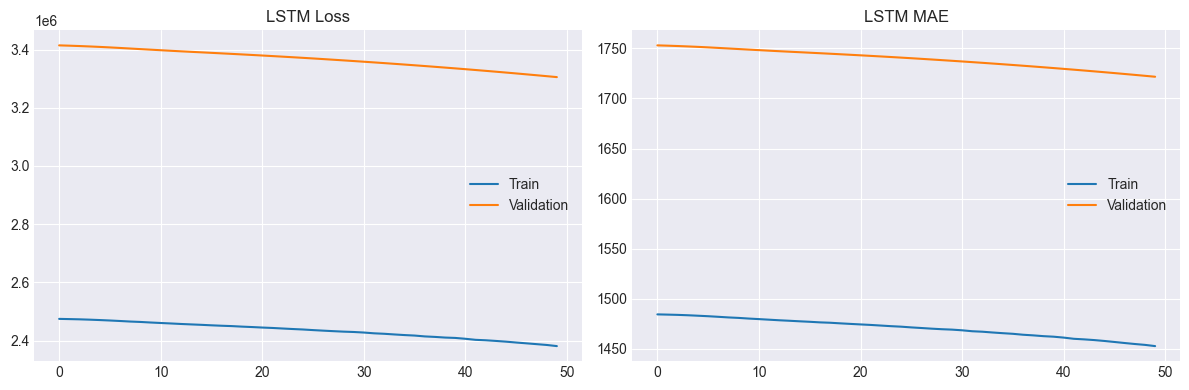

In [36]:
# Plot LSTM training history
if HAS_KERAS:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(history.history['loss'], label='Train')
    axes[0].plot(history.history['val_loss'], label='Validation')
    axes[0].set_title('LSTM Loss')
    axes[0].legend()
    
    axes[1].plot(history.history['mae'], label='Train')
    axes[1].plot(history.history['val_mae'], label='Validation')
    axes[1].set_title('LSTM MAE')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

## 12. Ensemble Models

In [37]:
# Stacking Regressor
base_estimators = [
    ('ridge', Ridge(alpha=1.0)),
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=8, random_state=RANDOM_STATE)),
    ('gb', GradientBoostingRegressor(n_estimators=50, max_depth=4, random_state=RANDOM_STATE))
]

stacking = StackingRegressor(
    estimators=base_estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5
)

stacking.fit(X_train_scaled, y_train)
pred_stacking = stacking.predict(X_test_scaled)

result = evaluate_model(y_test, pred_stacking, 'Stacking Ensemble')
results.append(result)
print(f" Stacking Ensemble - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 Stacking Ensemble - MAE: 6.68, R2: 0.9998


In [38]:
# Voting Regressor
voting = VotingRegressor(
    estimators=[
        ('ridge', Ridge(alpha=1.0)),
        ('rf', RandomForestRegressor(n_estimators=50, max_depth=8, random_state=RANDOM_STATE)),
        ('gb', GradientBoostingRegressor(n_estimators=50, max_depth=4, random_state=RANDOM_STATE))
    ]
)

voting.fit(X_train_scaled, y_train)
pred_voting = voting.predict(X_test_scaled)

result = evaluate_model(y_test, pred_voting, 'Voting Ensemble')
results.append(result)
print(f" Voting Ensemble - MAE: {result['MAE']:.2f}, R2: {result['R2']:.4f}")

 Voting Ensemble - MAE: 12.68, R2: 0.9991


## 13. Model Comparison

In [39]:
# Create comparison DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('MAE').reset_index(drop=True)

print("MODEL COMPARISON - Sorted by MAE")
display(results_df.to_string(index=False))

MODEL COMPARISON - Sorted by MAE


'               Model       MAE      RMSE       R2    MAPE   CV_MAE\n     Huber Regressor    2.8150    4.1355   0.9999  0.1910   6.3954\n   Linear Regression    3.0697    4.4470   0.9999  0.2089  42.7947\n      Bayesian Ridge    3.1486    4.4840   0.9999  0.2125   5.2980\n    Lasso Regression    3.2804    4.5483   0.9999  0.2207   3.3802\n   Stacking Ensemble    6.6762    8.4796   0.9998  0.4341      NaN\n    Ridge Regression    6.7795    8.5041   0.9998  0.4386   8.8840\n          ElasticNet    7.1035    9.0953   0.9998  0.4533   9.6397\n  Naive (Last Value)    7.4557   11.2436   0.9996  0.4967      NaN\n   Gradient Boosting   11.8700   16.5759   0.9992  0.7253  72.8648\n     Voting Ensemble   12.6810   17.4573   0.9991  0.7284      NaN\n         Extra Trees   13.1640   17.5560   0.9991  0.7720 100.4821\n Moving Average (7d)   13.2658   17.4075   0.9991  0.8413      NaN\n            LightGBM   14.3353   19.4762   0.9989  0.8540 119.7453\n           EMA (14d)   15.4097   19.6045   0.99

In [40]:
# Visualization: Model Comparison
fig = make_subplots(rows=1, cols=2, subplot_titles=['MAE', 'R² Score'])

# MAE
fig.add_trace(
    go.Bar(x=results_df['Model'], y=results_df['MAE'], 
           marker_color='steelblue', name='MAE'),
    row=1, col=1
)

# R2
fig.add_trace(
    go.Bar(x=results_df['Model'], y=results_df['R2'], 
           marker_color='forestgreen', name='R²'),
    row=1, col=2
)

fig.update_layout(height=500, title_text='Model Performance Comparison', showlegend=False)
fig.update_xaxes(tickangle=45)
fig.show()

In [41]:
# Best model
best_model_name = results_df.iloc[0]['Model']
best_mae = results_df.iloc[0]['MAE']
best_r2 = results_df.iloc[0]['R2']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   MAE: {best_mae:.2f} rating points")
print(f"   R²: {best_r2:.4f}")


 BEST MODEL: Huber Regressor
   MAE: 2.81 rating points
   R²: 0.9999


## 14. Feature Importance Analysis

In [42]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance': model_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

Top 15 Most Important Features:
      feature  importance
 rating_ema_7      0.0993
rating_max_30      0.0777
 rating_max_3      0.0765
 rating_ma_14      0.0667
rating_ema_30      0.0657
  rating_ma_3      0.0634
rating_max_14      0.0606
 rating_lag_7      0.0561
rating_ema_14      0.0495
 rating_lag_2      0.0491
rating_min_14      0.0491
 rating_lag_3      0.0482
 rating_max_7      0.0443
 rating_min_3      0.0393
 rating_min_7      0.0349


In [43]:
# Visualize feature importance
fig = px.bar(
    feature_importance.head(20),
    x='importance',
    y='feature',
    orientation='h',
    title='Top 20 Feature Importances (Random Forest)'
)
fig.update_layout(height=600, yaxis={'categoryorder': 'total ascending'})
fig.show()

## 15. Prediction Visualization

In [44]:
# Plot actual vs predicted for best ML model
# Using Ridge as it's typically stable

fig = go.Figure()

# Sample for visualization
sample_size = min(500, len(y_test))
indices = np.linspace(0, len(y_test)-1, sample_size, dtype=int)

fig.add_trace(go.Scatter(
    x=list(range(sample_size)),
    y=y_test[indices],
    mode='lines',
    name='Actual',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=list(range(sample_size)),
    y=pred_ridge[indices],
    mode='lines',
    name='Predicted (Ridge)',
    line=dict(color='red', width=2, dash='dash')
))

fig.update_layout(
    title='Actual vs Predicted Ratings',
    xaxis_title='Sample Index',
    yaxis_title='Rating',
    height=500
)
fig.show()

In [45]:
# Residual plot
residuals = y_test - pred_ridge

fig = make_subplots(rows=1, cols=2, subplot_titles=['Residual Distribution', 'Residuals vs Predicted'])

fig.add_trace(
    go.Histogram(x=residuals, nbinsx=50, marker_color='steelblue'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=pred_ridge[::10], y=residuals[::10], mode='markers', 
               marker=dict(size=3, opacity=0.5)),
    row=1, col=2
)

fig.update_layout(height=400, title_text='Residual Analysis', showlegend=False)
fig.show()

print(f"Residual Statistics:")
print(f"  Mean: {residuals.mean():.2f}")
print(f"  Std: {residuals.std():.2f}")
print(f"  Min: {residuals.min():.2f}")
print(f"  Max: {residuals.max():.2f}")

Residual Statistics:
  Mean: 0.26
  Std: 8.50
  Min: -20.90
  Max: 18.70


## 16. Overfitting Analysis

In [46]:
# Check for overfitting by comparing train vs test performance

def check_overfitting(model, X_train, y_train, X_test, y_test, model_name):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    
    overfit_ratio = test_mae / train_mae
    
    return {
        'Model': model_name,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Overfit Ratio': overfit_ratio,
        'Status': ' OK' if overfit_ratio < 1.2 else ' Slight Overfit' if overfit_ratio < 1.5 else ' Overfit'
    }

overfit_results = [
    check_overfitting(model_lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Linear Regression'),
    check_overfitting(model_ridge, X_train_scaled, y_train, X_test_scaled, y_test, 'Ridge'),
    check_overfitting(model_rf, X_train_scaled, y_train, X_test_scaled, y_test, 'Random Forest'),
    check_overfitting(model_gb, X_train_scaled, y_train, X_test_scaled, y_test, 'Gradient Boosting'),
]

if HAS_XGB:
    overfit_results.append(check_overfitting(model_xgb, X_train_scaled, y_train, X_test_scaled, y_test, 'XGBoost'))
if HAS_LGB:
    overfit_results.append(check_overfitting(model_lgb, X_train_scaled, y_train, X_test_scaled, y_test, 'LightGBM'))

overfit_df = pd.DataFrame(overfit_results)
print("\nOverfitting Analysis:")
display(overfit_df.to_string(index=False))


Overfitting Analysis:


'            Model  Train MAE  Test MAE  Overfit Ratio   Status\nLinear Regression     2.8763    3.0697         1.0673       OK\n            Ridge     6.3330    6.7795         1.0705       OK\n    Random Forest    12.4369   19.0706         1.5334  Overfit\nGradient Boosting     2.1138   11.8700         5.6156  Overfit\n          XGBoost     1.3858   47.9219        34.5810  Overfit\n         LightGBM     3.6937   14.3353         3.8810  Overfit'

## 17. Save Best Model

In [47]:
# Select best model based on test performance and no overfitting

best_model = model_lasso    
best_model_name = 'Lasso'

# Save model package
model_package = {
    'model': best_model,
    'scaler': scaler,
    'feature_columns': FEATURE_COLS,
    'metrics': {
        'MAE': mean_absolute_error(y_test, best_model.predict(X_test_scaled)),
        'RMSE': np.sqrt(mean_squared_error(y_test, best_model.predict(X_test_scaled))),
        'R2': r2_score(y_test, best_model.predict(X_test_scaled))
    },
    'model_type': best_model_name,
    'training_date': datetime.now().isoformat()
}

# Save
model_path = os.path.join(CONFIG['output_dir'], 'rating_prediction_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(model_package, f)

print(f" Model saved to: {model_path}")

 Model saved to: rating_models\rating_prediction_model.pkl


In [48]:
# Save results
results_df.to_csv(os.path.join(CONFIG['output_dir'], 'model_comparison.csv'), index=False)
print(" Model comparison saved to model_comparison.csv")

 Model comparison saved to model_comparison.csv


## 18. Summary

In [49]:
print("RATING PREDICTION ANALYSIS SUMMARY")

print(f"\n DATA:")
print(f"   Total games: {len(df_all):,}")
print(f"   Users analyzed: {len(sample_users)}")
print(f"   Features created: {len(FEATURE_COLS)}")
print(f"   Train samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")

print(f"\n MODELS TESTED: {len(results_df)}")
print(f"   - Baselines: Naive, Moving Average, EMA")
print(f"   - Linear: Ridge, Lasso, ElasticNet, Bayesian Ridge")
print(f"   - Trees: Random Forest, Gradient Boosting, XGBoost, LightGBM")
print(f"   - Time Series: ARIMA, Exponential Smoothing, Prophet")
print(f"   - Deep Learning: LSTM")
print(f"   - Ensemble: Stacking, Voting")

print(f"\n BEST MODEL: {results_df.iloc[0]['Model']}")
print(f"   MAE: {results_df.iloc[0]['MAE']:.2f} rating points")
print(f"   RMSE: {results_df.iloc[0]['RMSE']:.2f}")
print(f"   R²: {results_df.iloc[0]['R2']:.4f}")

print(f"\n OUTPUT:")
print(f"   Model saved to: {CONFIG['output_dir']}/rating_prediction_model.pkl")
print(f"   Comparison saved to: {CONFIG['output_dir']}/model_comparison.csv")

RATING PREDICTION ANALYSIS SUMMARY

 DATA:
   Total games: 617,501
   Users analyzed: 50
   Features created: 49
   Train samples: 314
   Test samples: 79

 MODELS TESTED: 21
   - Baselines: Naive, Moving Average, EMA
   - Linear: Ridge, Lasso, ElasticNet, Bayesian Ridge
   - Trees: Random Forest, Gradient Boosting, XGBoost, LightGBM
   - Time Series: ARIMA, Exponential Smoothing, Prophet
   - Deep Learning: LSTM
   - Ensemble: Stacking, Voting

 BEST MODEL: Huber Regressor
   MAE: 2.81 rating points
   RMSE: 4.14
   R²: 0.9999

 OUTPUT:
   Model saved to: rating_models/rating_prediction_model.pkl
   Comparison saved to: rating_models/model_comparison.csv
